## Object Detection

**Note:**  `py-espeak-ng` is only available Linux operating systems.

To run locally in a Linux machine, follow these commands:
```
    sudo apt-get update
    sudo apt-get install espeak-ng
    pip install py-espeak-ng
```

In [10]:
from transformers import pipeline

In [4]:
import io
import matplotlib.pyplot as plt
import requests
import inflect
from PIL import Image

#### `load_image_from_url`

In [5]:
def load_image_from_url(url):
    return Image.open(requests.get(url, stream=True).raw)

#### `render_results_in_image`

In [6]:
def render_results_in_image(in_pil_img, in_results):
    plt.figure(figsize=(16, 10))
    plt.imshow(in_pil_img)

    ax = plt.gca()

    for prediction in in_results:

        x, y = prediction['box']['xmin'], prediction['box']['ymin']
        w = prediction['box']['xmax'] - prediction['box']['xmin']
        h = prediction['box']['ymax'] - prediction['box']['ymin']

        ax.add_patch(plt.Rectangle((x, y),
                                   w,
                                   h,
                                   fill=False,
                                   color="green",
                                   linewidth=2))
        ax.text(
           x,
           y,
           f"{prediction['label']}: {round(prediction['score']*100, 1)}%",
           color='red'
        )

    plt.axis("off")

    # Save the modified image to a BytesIO object
    img_buf = io.BytesIO()
    plt.savefig(img_buf, format='png',
                bbox_inches='tight',
                pad_inches=0)
    img_buf.seek(0)
    modified_image = Image.open(img_buf)

    # Close the plot to prevent it from being displayed
    plt.close()

    return modified_image

#### `summarize_predictions_natural_language`

In [7]:
def summarize_predictions_natural_language(predictions):
    summary = {}
    p = inflect.engine()

    for prediction in predictions:
        label = prediction['label']
        if label in summary:
            summary[label] += 1
        else:
            summary[label] = 1

    result_string = "In this image, there are "
    for i, (label, count) in enumerate(summary.items()):
        count_string = p.number_to_words(count)
        result_string += f"{count_string} {label}"
        if count > 1:
          result_string += "s"

        result_string += " "

        if i == len(summary) - 2:
          result_string += "and "

    # Remove the trailing comma and space
    result_string = result_string.rstrip(', ') + "."

    return result_string

#### ignore warnings

In [8]:
import warnings
import logging
from transformers import logging as hf_logging

def ignore_warnings():
    # Ignore specific Python warnings
    warnings.filterwarnings("ignore", message="Some weights of the model checkpoint")
    warnings.filterwarnings("ignore", message="Could not find image processor class")
    warnings.filterwarnings("ignore", message="The `max_size` parameter is deprecated")

    # Adjust logging for libraries using the logging module
    logging.basicConfig(level=logging.ERROR)
    hf_logging.set_verbosity_error()

In [12]:
od_pipe = pipeline("object-detection", "facebook/detr-resnet-50")

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using a slow image processor as `use_fast` is unset and a slow processor was saved w

### What is Object Detection?

The task of object detection simply consists of detecting objects of interest in a specific image. 

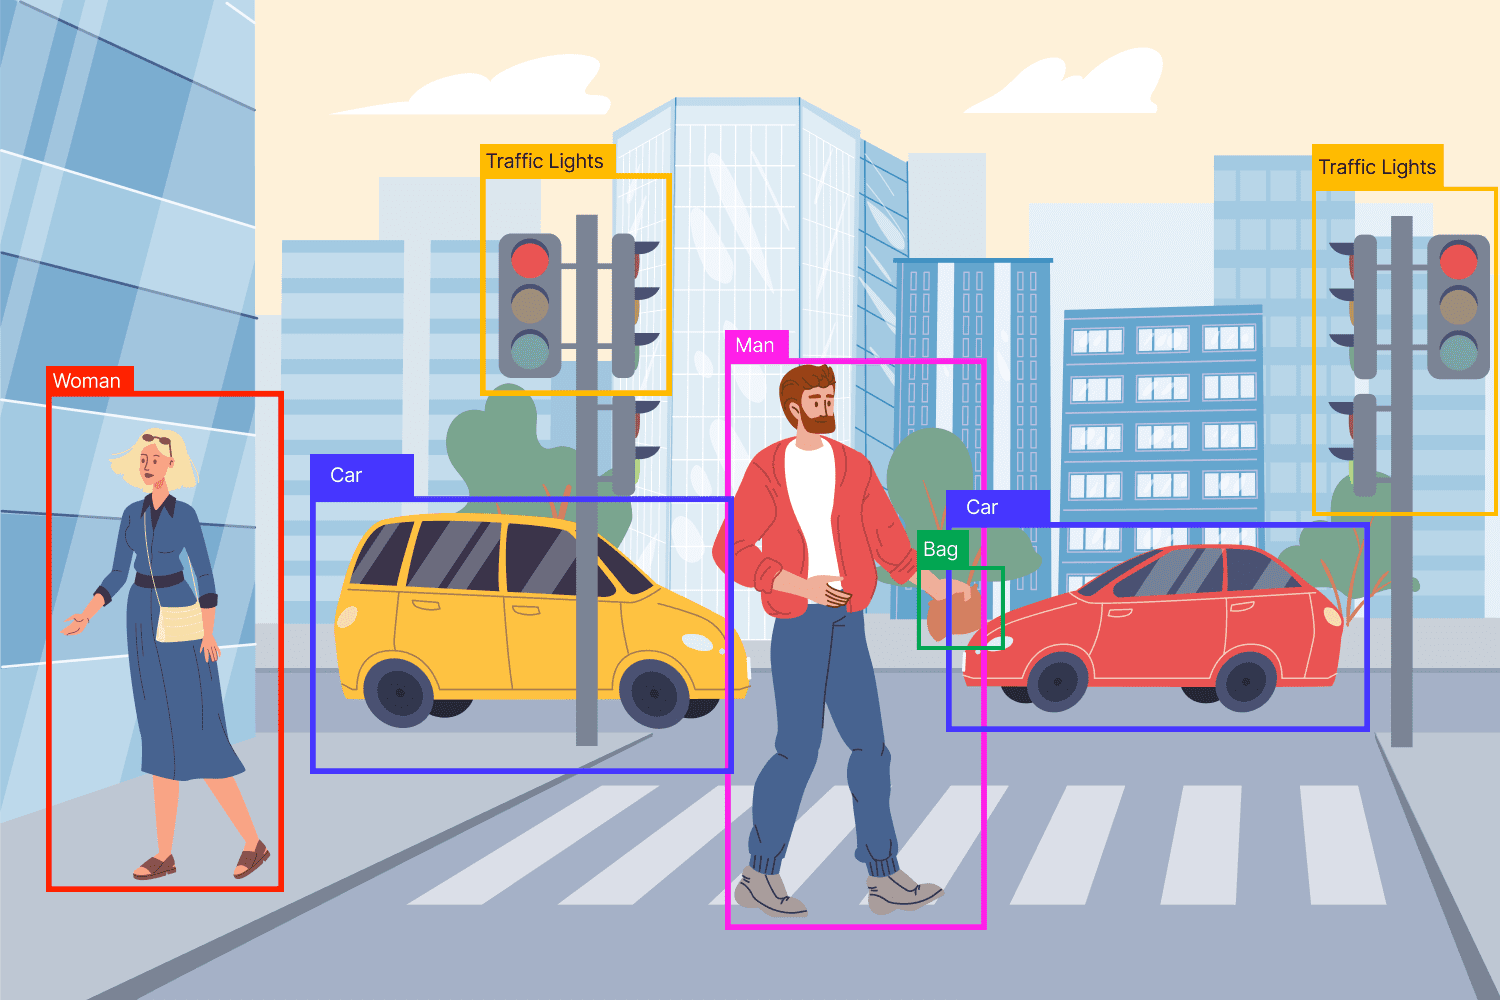

And one thing to notice is that object detection combines two subtasks, which are **classification**, but also **localization**.

Because for each object that you detect in an image, you also have to provide the label of the instance, but also the localization of the detected object. 

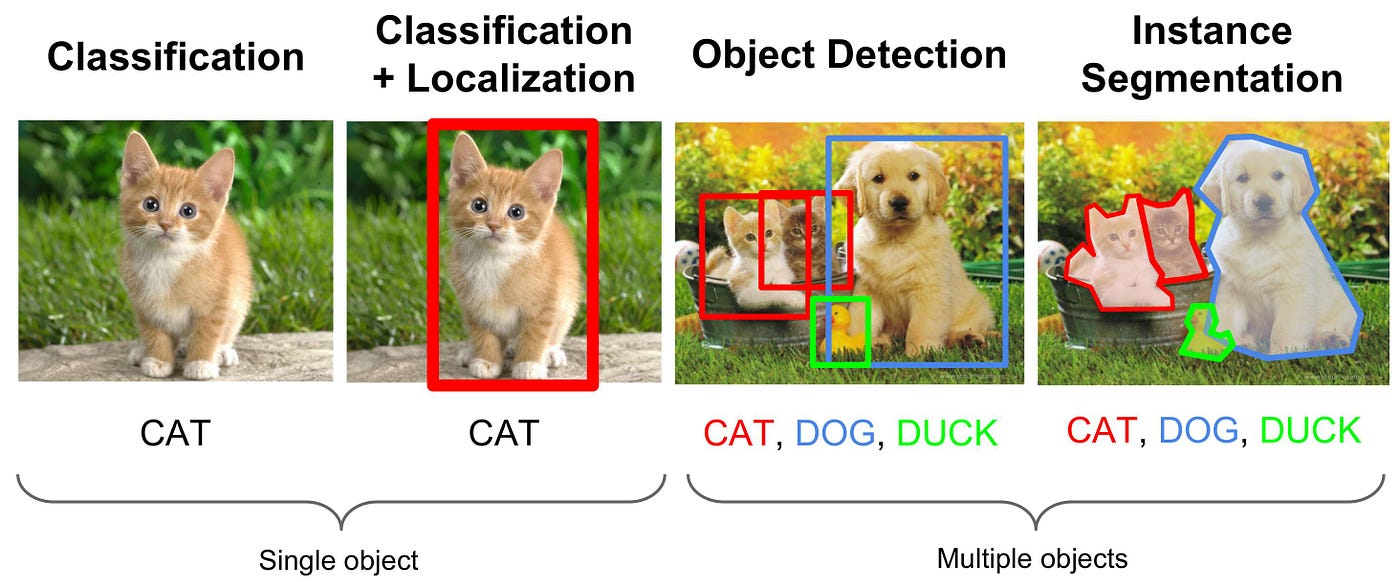

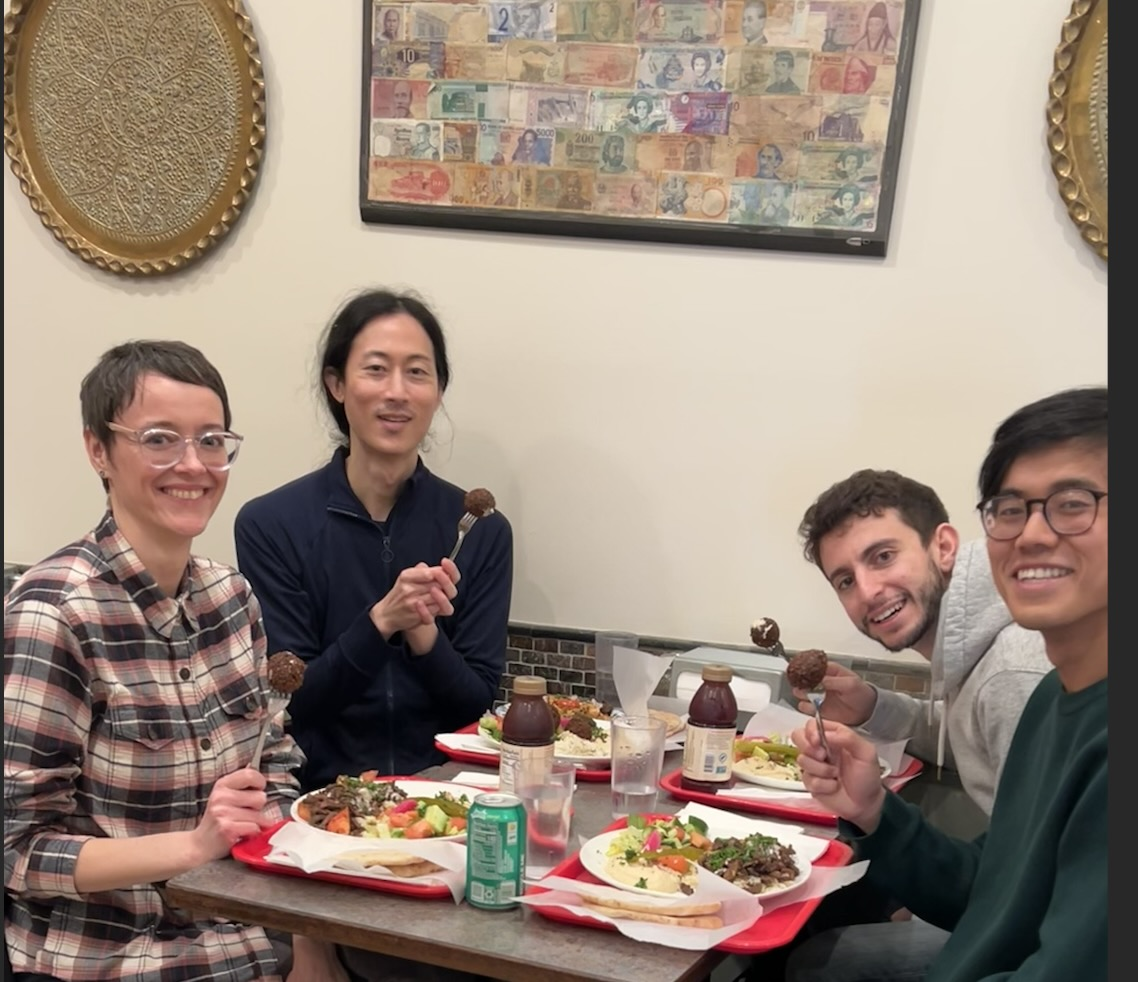

In [15]:
from PIL import Image
raw_image = Image.open('huggingface_friends.jpg')

raw_image

In [16]:
pipeline_output = od_pipe(raw_image)

In [17]:
processed_image = render_results_in_image(
    raw_image,
    pipeline_output
)

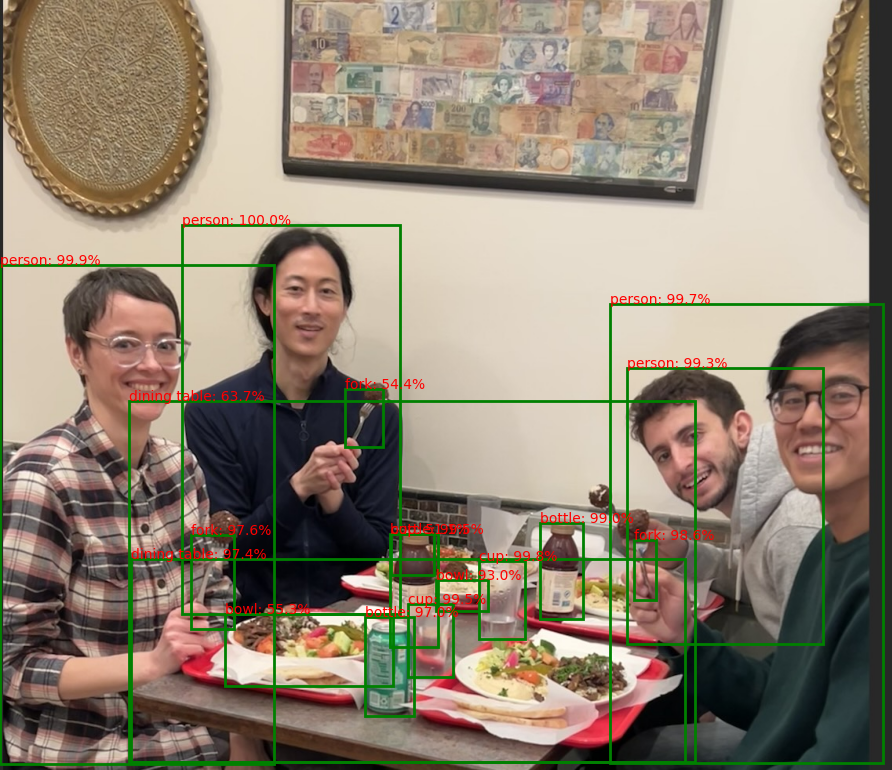

In [18]:
processed_image

### Make a Gradio demo!

With Gradio you can showcase your work to anyone easily!

In [19]:
import gradio as gr

def get_pipeline_prediction(pil_image):
    # First get the pipeline output given the pil image
    pipeline_output = od_pipe(pil_image)

    # Then process the image using the pipeline output
    processed_image = render_results_in_image(pil_image,
                                             pipeline_output)
    return processed_image

In [21]:
demo = gr.Interface(
    fn = get_pipeline_prediction,
    inputs= gr.Image(label = "Input image",
                    type = "pil"),
    outputs = gr.Image(label = "Output image with predicted instances",
                      type = "pil")
)

In [22]:
demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://8771d19786ca925f81.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Make an AI powered assistant

How to make an AI powered assistant using two different models. 

In [23]:
pipeline_output

[{'score': 0.5530938506126404,
  'label': 'bowl',
  'box': {'xmin': 286, 'ymin': 783, 'xmax': 501, 'ymax': 875}},
 {'score': 0.5437563061714172,
  'label': 'fork',
  'box': {'xmin': 439, 'ymin': 496, 'xmax': 488, 'ymax': 569}},
 {'score': 0.98568195104599,
  'label': 'fork',
  'box': {'xmin': 808, 'ymin': 688, 'xmax': 836, 'ymax': 765}},
 {'score': 0.9904234409332275,
  'label': 'bottle',
  'box': {'xmin': 688, 'ymin': 667, 'xmax': 743, 'ymax': 789}},
 {'score': 0.9948464632034302,
  'label': 'cup',
  'box': {'xmin': 520, 'ymin': 770, 'xmax': 577, 'ymax': 863}},
 {'score': 0.9971936941146851,
  'label': 'person',
  'box': {'xmin': 778, 'ymin': 387, 'xmax': 1125, 'ymax': 972}},
 {'score': 0.5112552642822266,
  'label': 'cup',
  'box': {'xmin': 498, 'ymin': 681, 'xmax': 553, 'ymax': 733}},
 {'score': 0.9695368409156799,
  'label': 'bottle',
  'box': {'xmin': 465, 'ymin': 786, 'xmax': 527, 'ymax': 912}},
 {'score': 0.9300816059112549,
  'label': 'bowl',
  'box': {'xmin': 556, 'ymin': 739,

In [24]:
od_pipe

In [25]:
text = summarize_predictions_natural_language(pipeline_output)

In [26]:
text

'In this image, there are two bowls three forks three bottles three cups four persons and two dining tables.'

In [27]:
from transformers import pipeline
tts_pipe = pipeline("text-to-speech",
                   model = "kakao-enterprise/vits-ljs")

Device set to use mps:0


In [28]:
narrated_text = tts_pipe(text)

RuntimeError: espeak not installed on your system

In [30]:
from IPython.display import Audio as IPythonAudio

IPythonAudio(narrated_text["audio"][0],
            rate = narrated_text["sampling_rate"])

NameError: name 'narrated_text' is not defined